# 1. 序列模型

## 1.2 训练

In [15]:
%matplotlib inline
import tensorflow as tf
import d2l

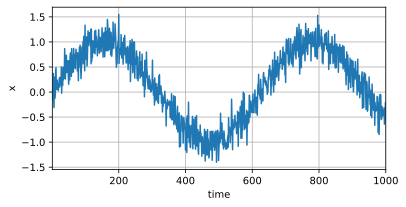

In [16]:
T = 1000
time = tf.range(1,T+1,dtype=tf.float32)
x = tf.sin(0.01*time)+tf.random.normal([T],0,0.2)
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [4]:
tau = 4
features = tf.Variable(tf.zeros((T-tau,tau)))
for i in range(tau):
    features[:,i].assign(x[i:T-tau+i])
labels = tf.reshape(x[tau:],(-1,1))
batch_size,n_train = 16,600
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

In [9]:
features

<tf.Variable 'Variable:0' shape=(996, 4) dtype=float32, numpy=
array([[-0.33488446,  0.12458295,  0.09246019, -0.08052905],
       [ 0.12458295,  0.09246019, -0.08052905, -0.5285923 ],
       [ 0.09246019, -0.08052905, -0.5285923 ,  0.18501864],
       ...,
       [-0.25885695, -0.69374794, -0.4741521 , -0.53652185],
       [-0.69374794, -0.4741521 , -0.53652185, -0.5497533 ],
       [-0.4741521 , -0.53652185, -0.5497533 , -0.5045234 ]],
      dtype=float32)>

In [5]:
def get_net():
    net = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'),tf.keras.layers.Dense(1)])
    return net

loss = tf.keras.losses.MeanSquaredError()

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

2022-01-12 15:19:59.215426: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


epoch 1, loss: 1.548228
epoch 2, loss: 0.819350
epoch 3, loss: 0.422318
epoch 4, loss: 0.226958
epoch 5, loss: 0.132758


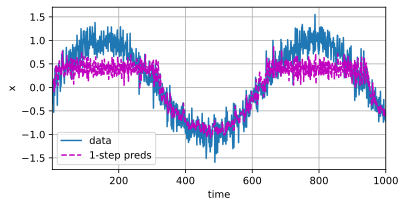

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

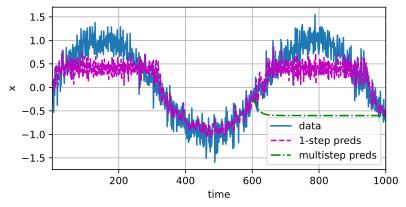

In [8]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.numpy(), onestep_preds.numpy(),
          multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

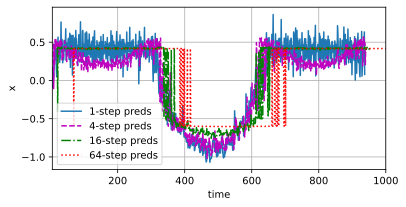

In [10]:
max_steps = 64

features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau: i])), -1))

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

# 2. 文本预处理

In [1]:
import collections
import re
import d2l

## 2.1 读取数据集

In [2]:
lines = d2l.read_time_machine()

In [3]:
print(f'#文本总行数：{len(lines)}')

#文本总行数：3221


In [4]:
print(lines[0])

the time machine by h g wells


In [5]:
print(lines[10])

twinkled and his usually pale face was flushed and animated the


## 2.2 词元化

In [6]:
tokens = d2l.tokenize(lines)

In [7]:
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 2.3 词表

词元是字符串，而模型的输入是数字，因此需要构建一个词表来将词元映射到从0开始的数字索引中，词表是一个字典。

In [9]:
vocab = d2l.Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('the', 0), ('i', 1), ('and', 2), ('of', 3), ('a', 4), ('to', 5), ('was', 6), ('in', 7), ('that', 8), ('my', 9)]


# 3. 语言模型和数据集

为了训练语言模型，我们需要计算单词的概率，以及给定前面几个单词后，出现某个单词的条件概率。

In [1]:
import random
import tensorflow as tf
import d2l

## 3.3 自然语言统计

齐普夫定律：
第$i$个最常用单词的频率$n_i$为：
$$
n_i \propto \frac1{i^{\alpha}}
$$

即：
$$
\log n_i = -\alpha \log i + c
$$

## 3.4 读取长序列数据

### 3.4.1 随机采样

在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。在迭代过程中，两个相邻的子序列不一定在原始序列上相邻。

### 3.4.2 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外， 我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。

In [ ]:
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    offset = 

# 4. 循环神经网络

## 4.4 困惑度

一个更好的语言模型应该能更准确地预测下一个词元，因此，它应该允许我们在压缩序列时花费更少的比特。 所以我们可以通过一个序列中所有的 n 个词元的交叉熵损失的平均值来衡量：
$$
-\frac1n \sum_{t=1}^n \log P(x_t|x_{t-1},\dots,x_1)
$$

困惑度：
$$
\exp (-\frac1n \sum_{t=1}^n \log P(x_t|x_{t-1},\dots,x_1))
$$

困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。
- 在最好的情况下，模型总是完美地估计标签词元的概率为1。 在这种情况下，模型的困惑度为1。
- 在最坏的情况下，模型总是预测标签词元的概率为0。 在这种情况下，困惑度是正无穷大。
- 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。 在这种情况下，困惑度等于词表中唯一词元的数量。 事实上，如果我们在没有任何压缩的情况下存储序列， 这将是我们能做的最好的编码方式。 因此，这种方式提供了一个重要的上限， 而任何实际模型都必须超越这个上限。

# 5. RNN的从零开始实现

In [1]:
%matplotlib inline
import math
import tensorflow as tf
import d2l

In [ ]:
batch_size,num_steps = 32,35
train_iter,vocab = d2l.loa

## 5.1 one-hot encoding

# 6. 简洁实现

In [1]:
import tensorflow as tf
import d2l

In [2]:
batch_size,num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [4]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell,time_major=True,return_sequences=True,return_state=True)

state = rnn_cell.get_initial_state(batch_size=batch_size,dtype=tf.float32)
state.shape

TensorShape([32, 256])

In [5]:
class RNNModel(tf.keras.layers.Layer):
    def __init__(self,rnn_layer,vocab_size,**kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self,inputs,state):
        X = tf.one_hot(tf.transpose(inputs),self.vocab_size)
        Y,*state = self.rnn(X,state)
        output = self.dense(tf.reshape(Y,(-1,Y.shape[-1])))
        return output,state
    
    def begin_state(self,*args,**kwargs):
        return self.rnn.cell.get_initial_state(*args,**kwargs)

In [13]:
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))
        # Keras默认返回一个批量中的平均损失
        metric.add(l * tf.size(y), tf.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [7]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [9]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

In [11]:
def grad_clipping(grads, theta):
    """裁剪梯度"""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Mul]

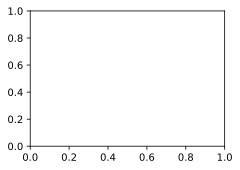

In [14]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)